# Metric learning

Задание 6

Обучить сиамскую сеть для верификации лиц на датасете LFW
Библиотеки: [Python, Tensorflow]

In [1]:
%tensorflow_version 2.x

UsageError: Line magic function `%tensorflow_version` not found.


In [4]:
%matplotlib inline
import numpy as np
import os
import cv2
import tarfile
import tqdm
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

import time
import keras
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras import backend as K
import pandas as pd
import sys # Для sys.exit()
import struct # Для вывода в файл и последующей загрузки
from sklearn.model_selection import train_test_split

In [5]:
IMAGES_FILE = 'lfw_deepfunneled.tgz'

**Рассматриваемая ниже нейронная сеть решает задачу верификации. На вход обученной нейронной сети, имеющей два выхода, подаются два изображения. Оба изображения имеют метку 0, если на них одно лицо, и метку 1 – в противном случае. Категориальное представление метки 0 – это вектор [1, 0], метки 1 – вектор [0, 1].
На выходе нейронной сети формирует вектор [y0, y1] и относит изображения к одному лицу, если y0 > y1, и к разным лицам – в противном случае.**

Загрузка датасета

In [36]:
class LFWLoder:
    
    def __init__(self, dx = 61, dy = 61, dim_x = 48, dim_y = 48, use_margins = True):
        self.dx=dx
        self.dy=dy
        self.dim_x=dim_x
        self.dim_y=dim_y
        self.use_margins=use_margins               
        
    def decode_image_from_raw_bytes(self,raw_bytes):
        img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype = np.uint8), 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img

    def load_dataset(self):
        all_photos = []
        photo_ids = []
        with tarfile.open(IMAGES_FILE) as f:
            for m in tqdm.tqdm_notebook(f.getmembers()):
                name = m.name # Имя файла, например,  Art_Hoffmann_0002.jpg
                if m.isfile() and name.endswith('.jpg'):
                    # Подготовка изображения
                    img = self.decode_image_from_raw_bytes(f.extractfile(m).read())
                    if self.use_margins: img = img[self.dy:-self.dy, self.dx:-self.dx]
                    img = cv2.resize(img, (self.dim_x, self.dim_y))
                    # Имя, фамилия персоны и номер фотографии
                    fname = os.path.split(name)[-1]
                    fname_splitted = fname[:-4].replace('_', ' ').split()
                    person_id = ' '.join(fname_splitted[:-1])
                    photo_number = int(fname_splitted[-1])
                    all_photos.append(img)
                    photo_ids.append([photo_number, person_id])
        all_photos2 = []
        photo_ids2 = []
        i = 0
        cnt = len(photo_ids) - 1
        ind = 0
        while i < cnt:
            nm = photo_ids[i][1]
            i += 1
            if photo_ids[i][1] == nm:
                added = True
                tmp = photo_ids[i - 1]
                tmp[0] = ind
                photo_ids2.append(tmp)
                all_photos2.append(all_photos[i - 1])
                while photo_ids[i][1] == nm and i < cnt:
                    photo_ids2.append(tmp)
                    all_photos2.append(all_photos[i])
                    i += 1
                ind += 1
            else:
                added = False
        if added:
            photo_ids2.append(tmp)
            all_photos2.append(all_photos[i - 1])
        all_photos2 = np.stack(all_photos2).astype('uint8')
        return all_photos2, photo_ids2

<ipython-input-36-dd15fede50c1>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for m in tqdm.tqdm_notebook(f.getmembers()):


  0%|          | 0/13233 [00:00<?, ?it/s]

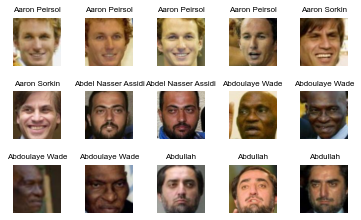

In [37]:
loader=LFWLoder(dim_x = 250, dim_y = 250, use_margins = True)
all_photos, photo_ids = loader.load_dataset()
title_font = {'fontname':'Arial', 'size':'8', 'color':'black'}
for i in range(15):
    plt.subplot(3, 5, i + 1)
    psn = all_photos[i]
    plt.title(photo_ids[i][1], **title_font)
    plt.imshow(psn)
    plt.axis('off')
plt.subplots_adjust(hspace = 0.05, wspace = 0.5)
plt.show()

Формирование обучающей выборки

Обучающая выборка содержит пары фотографий, принадлежащих одному лицу, и пары фотографий, принадлежащих разным лицам. Первые пары имеют метку 0, вторые – 1. Число пар с метками 0 и 1 одинаково.
Пары с меткой 0 ( пары для одинаковых персон создаются функцией make_same_person_pairs, а с меткой 1 ( пары для разнызх персон) – функцией make_different_person_pairs:

In [38]:
MAX_FOTOS_PER_PERSON = 23
class PersonPairsMaker:
    def make_same_person_pairs(self,photos, labels, nPh):
        # Создаем пары для каждой персоны, сочетая первую фотографию со второй
        # вторую с третьей и т. д.
        # Если пара фотографий принадлежит одной персоне, то photos_class[*] = 0,
        # в противном случае photos_class[*] = 1
        photos_02, ids_02, photos_class = [], [], []
        sz = photos[0].shape[0]
        i = 0
        while i < nPh - 1:
            j = i
            lb = labels[j]
            L = 0
            while i < nPh and labels[i] == lb:
                i += 1
                L += 1
            if i < nPh:
                for m in range(1, L):
                    arrP = np.zeros(shape = (sz, sz, 6), dtype = np.uint8)
                    arr_ids = np.zeros(shape = (3, 1), dtype = np.int32)
                    arrP[:, :, 0:3] = photos[j + m - 1]
                    arrP[:, :, 3:6] = photos[j + m]
                    arr_ids[0, 0] = lb
                    arr_ids[1, 0] = lb
                    arr_ids[2, 0] = m # Номер пары текущего лица
                    photos_02.append(arrP)
                    ids_02.append(arr_ids)
                    photos_class.append(0)
        return photos_02, ids_02, photos_class

    def make_different_person_pairs(self,photos, labels, nPh, nPairs, photos_02, ids_02, photos_class):
        # nPairs - число пар для одинаковых персон в photos_02 (результат make_same_person_pairs)
        # Создаем nPairs пар, сочетая фотографии разных персон
        # В этом случае photos_class[*] = 1
        sz = photos[0].shape[0]
        n = 0
        for s in range(MAX_FOTOS_PER_PERSON):
            ph_temp, ids_temp = [], []
            i = 0
            while i < nPh - 1:
                j = i
                lb = labels[j]
                k = 0
                while i < nPh and labels[i] == lb:
                    i += 1
                    k += 1
                if i < nPh and k > s:
                    ph_temp.append(photos[j + s])
                    ids_temp.append(lb)
            amt = len(ph_temp) - 1
            for i in range(amt):
                arrP = np.zeros(shape = (sz, sz, 6), dtype = np.uint8)
                arr_ids = np.zeros(shape = (3, 1), dtype = np.int32)
                arrP[:, :, 0:3] = ph_temp[i]
                arrP[:, :, 3:6] = ph_temp[i + 1]
                arr_ids[0, 0] = ids_temp[i]
                arr_ids[1, 0] = ids_temp[i + 1]
                arr_ids[2, 0] = s # Номер пары текущего лица
                photos_02.append(arrP)
                ids_02.append(arr_ids)
                photos_class.append(1)
                n += 1
                if n >= nPairs: return photos_02, ids_02, photos_class
        return photos_02, ids_02, photos_class

In [39]:
class Saver:

    def saveToFiles(self,fn, nPh, all_photos, photo_ids):
        fn2 = fn + '.bin'
        fn3 = fn + '_id.bin'
        fn4 = fn + '_names.txt'
        fp = open('amt.bin', 'wb')
        fp2 = open(fn2, 'wb')
        fp3 = open(fn3, 'wb')
        fp.write(struct.pack('i', nPh))
        fp2.write(all_photos)
        fp.close()
        fp2.close()
        names = []
        for i in range(nPh):
            fp3.write(struct.pack('i', photo_ids[i][0]))
            nm = photo_ids[i][1]
            if nm not in names: names.append(nm)
        fp3.close()
        fp4 = open(fn4, 'w')
        for m in names:
            fp4.write(m + '\n')
        fp4.close()
        print('Сохранены файлы amt.bin, ' + fn2 + ', ' + fn3 + ' и ' + fn4)
    def saveToBin(self):
        print('Сохраняем данные в двоичные и текстовый файлы')
        show = False # False True
        if show:
            all_photos, photo_ids = load_dataset(dim_x = 250, dim_y = 250, go = False)
        else:
            all_photos, photo_ids = load_dataset(dim_x = w, dim_y = h, go = True)
        print(type(all_photos)) # class 'numpy.ndarray'
        print(type(photo_ids)) # class 'list'
        print(len(all_photos), len(photo_ids)) # 9164 9164
        print(all_photos.shape) # (9164, 128, 128, 3) if show else (9164, w, h, 3)
        ##print(photo_ids[:20])
        # [[0, 'Aaron Peirsol'], [0, 'Aaron Peirsol'], [0, 'Aaron Peirsol'], [0, 'Aaron Peirsol'],
        # [1, 'Aaron Sorkin'], [1, 'Aaron Sorkin'],
        # [2, 'Abdel Nasser Assidi'], [2, 'Abdel Nasser Assidi'],
        # [3, 'Abdoulaye Wade'], [3, 'Abdoulaye Wade'], [3, 'Abdoulaye Wade'], [3, 'Abdoulaye Wade'],
        # [4, 'Abdullah'], [4, 'Abdullah'], [4, 'Abdullah'], [4, 'Abdullah'],
        # [5, 'Abdullah Gul'], [5, 'Abdullah Gul'], [5, 'Abdullah Gul'], [5, 'Abdullah Gul']]
        if show:
            title_font = {'fontname':'Arial', 'size':'8', 'color':'black'}
            for i in range(15):
                plt.subplot(3, 5, i + 1)
                psn = all_photos[i]
                plt.title(photo_ids[i][1], **title_font)
                plt.imshow(psn)
                plt.axis('off')
            plt.subplots_adjust(hspace = 0.05, wspace = 0.5)
            plt.show()
        nPh = len(photo_ids)
        saveToFiles(fn, nPh, all_photos, photo_ids)
        sys.exit()

In [40]:
class DataPreparation:

    def loadDataFromBinFiles(self,fn, w, h):
        print('Загрузка данных из двоичных файлов')
        fn0 = 'amt.bin'
        fn2 = fn + '.bin'
        fn3 = fn + '_id.bin'
        fn4 = fn + '_names.txt'
        fp = open(fn0, 'rb')
        nPh = fp.read()
        fp.close()
        nPh = struct.unpack('i', nPh) # (9164,)
        with open(fn2, 'rb') as read_binary:
            photos = np.fromfile(read_binary, dtype = np.uint8)
        with open(fn3, 'rb') as read_binary:
            labels = np.fromfile(read_binary, dtype = np.int32)
        #with open(fn4, 'r') as f: names = f.read() # Имена персон
        #names = names.split('\n') # Строку в список
        #if names[len(names) - 1] == '': del names[-1]
        return nPh[0], photos.reshape(nPh[0], w, h, 3), labels

    def prepData(self,fn, w, h, useTest):
        person_pairs_maker = PersonPairsMaker()
        # Каждая персона при загрузке данных получила номер: 0, 1, ...; эти номера содержит массив labels
        nPh, photos, labels = self.loadDataFromBinFiles(fn, w, h) # nPh = 9164; photos - numpy.ndarray
        ##showPics(True, photos, labels) # False True
        ##sys.exit()
        #
        # Создаем хорошие пары для каждой персоны, сочетая первую фотографию со второй, вторую с третьей и т. д.
        photos_02, ids_02, photos_class = person_pairs_maker.make_same_person_pairs(photos, labels, nPh)
        nGood = len(photos_class) # Число хороших пар
        # Создаем плохие пары для каждой персоны
        photos_02, ids_02, photos_class = person_pairs_maker.make_different_person_pairs(photos, labels, nPh, len(photos_02), photos_02, ids_02, photos_class)
        nBad = len(photos_class) - nGood
        print('Число пар с одинаковыми персонами:', nGood) # 7481
        print('Число пар с разными персонами:', nBad) # 7481
        # 1: False True - показываем хорошие пары; 2: False True - выводим заголовок
        ##showPairs(photos_02, ids_02, True, True, nGood, nBad)
        ##sys.exit()
        photos_02 = np.array(photos_02)
        photos_class = np.array(photos_class)
        ##print(photos_02.shape) # (14962, w, h, 6)
        #
        if useTest:
            X_train, X_test, y_train, y_test = train_test_split(photos_02, photos_class, test_size = 0.1, random_state = 348)
            y_test_0 = y_test
            n_test = len(y_test)
            print('Размер тестовой выборки:', n_test)
        else:    
            X_train, y_train = photos_02, photos_class
            X_test = y_test = y_test_0 = n_test = 0
        #
        ##showPairs(X_train, y_train, True)
        ##showPairs(X_test, y_test, True)
        ##sys.exit()
        #
        # Преобразование из диапазона 0-255 в диапазон 0.0-1.0
        X_train = X_train.astype('float32')
        X_train = X_train / 255.0
        y_train = keras.utils.to_categorical(y_train, 2)
        if useTest:
            X_test = X_test.astype('float32')
            X_test = X_test / 255.0
            y_test = keras.utils.to_categorical(y_test, 2)
        return X_train, X_test, y_train, y_test, y_test_0, n_test

## Создание модели CNN

In [41]:
class PicturesShower:

    def showPics(self,show, photos, labels):
        if show:
            for i in range(40):
                plt.subplot(5, 8, i + 1)
                psn = photos[i]
                plt.title(labels[i])
                plt.imshow(psn)
                plt.axis('off')
            plt.subplots_adjust(hspace = 0.05, wspace = 0.25)
            plt.show()
            sys.exit()
    def showOnePic(self,i, j, photos_02, ids_02, k, L, m, showTitle):
        j += 1
        plt.subplot(5, 8, j)
        psn = photos_02[i][:, :, k:L] # или photos_02[i, :, :, k:L], если photos_02 - это массив
        if showTitle:
            plt.title(str(ids_02[i][m, 0]) + '_' + str(ids_02[i][2, 0]))
        else:
            plt.title(str(ids_02[i]))
        plt.imshow(psn)
        plt.axis('off')
        return j
    def showPairs(self,photos_02, ids_02, first, showTitle = False, nGood = 0, nBad = 0):
        j = 0
        for i in range(0, 20):
            k = i if first else np.random.choice(range(nGood, nGood + nBad))
            j = showOnePic(k, j, photos_02, ids_02, 0, 3, 0, showTitle)
            j = showOnePic(k, j, photos_02, ids_02, 3, 6, 1, showTitle)
        plt.show()

In [42]:
class CNNModel:
    
    def createModel(self,input_shape, loss, optimizer):
        print('Функция потерь:', loss)
        visible = Input(shape = input_shape)
        conv = Conv2D(16, kernel_size = (3, 3), padding = 'same', activation = 'relu')(visible)
        pool = MaxPooling2D(pool_size = (2, 2), padding = 'same')(conv)
        conv2 = Conv2D(48, kernel_size = (3, 3), padding = 'same', activation = 'relu')(pool)
        pool2 = MaxPooling2D(pool_size = (2, 2), padding = 'same')(conv2)
        flat = Flatten()(pool2)
        # Интерпретирующая часть модели
        dense = Dense(1024, activation = 'relu')(flat)
        ##drop = Dropout(0.2)(dense)
        dense2 = Dense(64, activation = 'relu')(dense) # linear relu
        output = Dense(2, activation = 'softmax')(dense2)
        model = Model(inputs = visible, outputs = output)
        #
        model.summary()
        ##plot_model(model, to_file = 'lfw.png')
        #
        model.compile(loss = loss, optimizer = optimizer, metrics = ['accuracy']) # binary_accuracy
        return model
    
    def checkModel(self,model, X_test, y_test, y_test_0, predict, n_test, useTest, showErrPics):
        if not useTest: predict = False
        if predict:
            shower = PicturesShower()
            print('Прогнозирование')
            y_pred = model.predict(X_test) # , batch_size = 10
            classes = []
            for m in y_pred:
                classes.append(np.argmax(m))
            # np.sum(classes == y_test_0) вернет сумму случаев, когда classes[i] = y_test_0[i]
            nClassified = np.sum(classes == y_test_0)
            nNotClassified = n_test - nClassified
            acc = 100.0 * nClassified / n_test
            print("Число ошибочно классифицированных лиц: " + str(nNotClassified))
            print("Точность прогнозирования: " + str(acc) + '%')
            if showErrPics:
                n = 0
                j = 0
                for i in range(n_test):
                    if y_test_0[i] != classes[i]:
                        n += 1
                        if (n > nNotClassified): break
                        print(str(n) + '. i = ' + str(i))
                        if j < 40:
                            j = shower.showOnePic(i, j, X_test, y_test_0, 0, 3, 0, False)
                            j = shower.showOnePic(i, j, X_test, y_test_0, 3, 6, 1, False)
                plt.show()        
        else:
            print('Тестирование')
            start_time = time.time()
            if useTest:
                score = model.evaluate(X_test, y_test, verbose = 0)
            else:
                score = model.evaluate(X_train, y_train, verbose = 0)
            print('Потери при тестировании: ', score[0])
            print('Точность при тестировании:', score[1])
            print('Время тестирования: ', (time.time() - start_time))
            
    def myLoss(self,y_true, y_pred):
        dist = K.sqrt(K.sqrt(K.sum(K.square(y_pred - y_true))))
        err = dist
        return err # Вернет тензор с shape=(?,)

Загрузка данных из двоичных файлов
Число пар с одинаковыми персонами: 7481
Число пар с разными персонами: 7481
Размер тестовой выборки: 1497
Функция потерь: <function poisson at 0x0000021845813670>
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 6)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 48, 16)        880       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 48)        6960      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 48)        0         
_____________________________________________________________

<ipython-input-43-e2b94e147dbc>:84: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Число ошибочно классифицированных лиц: 405
Точность прогнозирования: 72.94589178356713%
1. i = 5
2. i = 8
3. i = 15
4. i = 17
5. i = 25
6. i = 28
7. i = 30
8. i = 34
9. i = 36
10. i = 37
11. i = 42
12. i = 43
13. i = 48
14. i = 50
15. i = 51
16. i = 52
17. i = 61
18. i = 67
19. i = 68
20. i = 70
21. i = 77
22. i = 78
23. i = 84
24. i = 87
25. i = 90
26. i = 91
27. i = 93
28. i = 99
29. i = 108
30. i = 110
31. i = 116
32. i = 118
33. i = 122
34. i = 124
35. i = 128
36. i = 132
37. i = 134
38. i = 135
39. i = 137
40. i = 141
41. i = 148
42. i = 150
43. i = 158
44. i = 159
45. i = 164
46. i = 174
47. i = 180
48. i = 188
49. i = 189
50. i = 193
51. i = 196
52. i = 200
53. i = 201
54. i = 204
55. i = 210
56. i = 216
57. i = 223
58. i = 225
59. i = 226
60. i = 229
61. i = 230
62. i = 231
63. i = 247
64. i = 249
65. i = 250
66. i = 251
67. i = 252
68. i = 260
69. i = 261
70. i = 263
71. i = 267
72. i = 273
73. i = 276
74. i = 281
75. i = 285
76. i = 288
77. i = 290
78. i = 291
79. i = 298
80.

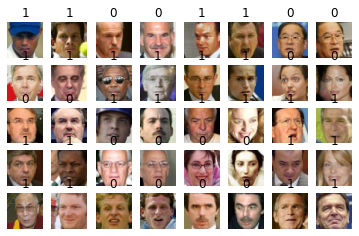

In [43]:
data_preparation = DataPreparation()
model_preparation = CNNModel()

pathToData = 'C:/Users/Windows/Documents/Deep_Learning_In_Computer_Vision/Lesson6/'
# Имя hdf5-файла с весами модели. Используется, когда loadModel = True
fileWeights = pathToData + 'weights.11' + '.hdf5' # Файл с весами модели (loadModel)
filepath = pathToData + "weights_2.{epoch:02d}.hdf5" # Шаблон файла для сохранения весов модели
# Загрузка весов из ранее сохраненного файла
loadModel = False # False False
# Флаг обучения модели
fitModel = True # True False
useTest = True # True False
predict = False
showErrPics = True
showFig = True
epochs = 30
#
w = h = 48
input_shape = (w, h, 6)
userLoss = False # False True
if userLoss:
    loss = model_preparation.myLoss
else:
    loss = keras.losses.poisson
save_lfw = False 
optimizer = keras.optimizers.Adam()
fn = 'photos' # Начало имени бинарных файлов, в которые выгружаются фотогграфии лиц и их идентификаторы
batch_size = 256
#
np.random.seed(348)
#
if save_lfw: 
    saver=Saver()
    saver.saveToBin()
#
# Загружаем и готови бучающие и тестовые данные
X_train, X_test, y_train, y_test, y_test_0, n_test = data_preparation.prepData(fn, w, h, useTest)
#
# Создаем модель нейронной сети
model = model_preparation.createModel(input_shape, loss, optimizer)
#
if loadModel:
    print('Загрузка весов из файла ' + fileWeights)
    model.load_weights(fileWeights)
if fitModel:
    print('Обучение')
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor = 'val_loss', verbose = 0,
                                                 save_weights_only = True,
                                                 save_best_only = False, mode = 'min', period = 1)
    callbacks_list = [checkpoint]
    start_time = time.time()
    history = model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs,
                        verbose = 2, validation_data = (X_test, y_test), callbacks = callbacks_list)
    print('Число эпох: ', epochs)
    print('batch_size = ', batch_size)
    print('Время обучения: ', (time.time() - start_time))
    # Вывод истории в файлы
    suff = '.txt'
    f_loss = 'loss' + suff
    f_acc = 'acc' + suff
    f_val_loss = 'val_loss' + suff
    f_val_acc = 'val_acc' + suff
    print('История сохранена в файлы ' + f_loss + ', ' + f_acc + ', ' + f_val_loss + ' и ' + f_val_acc)
    with open(pathToData + f_loss, 'w') as output:
        for val in history.history['loss']: output.write(str(val) + '\n')
    with open(pathToData + f_acc, 'w') as output:
        for val in history.history['accuracy']: output.write(str(val) + '\n')
    with open(pathToData + f_val_loss, 'w') as output:
        for val in history.history['val_loss']: output.write(str(val) + '\n')
    with open(pathToData + f_val_acc, 'w') as output:
        for val in history.history['val_accuracy']: output.write(str(val) + '\n')
    if showFig and not predict:
        # Вывод графиков
        yMax = max(history.history['accuracy'])
        cnt = len(history.history['accuracy'])
        rng = np.arange(cnt)
        fig, ax = plt.subplots(figsize = (6.2, 3.8))
        ax.scatter(rng, history.history['accuracy'], marker = 'o', c = 'blue', edgecolor = 'black', label = 'Точность')
        ax.set_title('Точность в процессе обучения')
        ax.set_ylabel('Точность')
        ax.set_xlabel('Эпоха')
        ax.set_xlim([0.9, 1.1 * (cnt - 1)])
        ax.set_ylim([0, 1.1 * yMax])
        fig.show()
# Проверка
predict=True
model_preparation.checkModel(model, X_test, y_test, y_test_0, predict, n_test, useTest, showErrPics)

In [44]:
X_train[0].shape

(48, 48, 6)

In [45]:
 y_train[0].shape

(2,)